# Mathematical model of antibiotic resistance N. gonorrhoeae spread

### Transmission model
* $Sen$ and $Res$ indicate the antibitotic-sensitive and -resistand N. gonorrhoeae strains
* $G = \{L,H\}$ is the set of low and high sexual activity groups, $i \in G$
* Each sexual activity group $N_i$ consists of:
    * susceptible hosts $S_i$
    * hosts infected with an antibiotic-sensitive strain, $I_{Sen_i}$
    * hosts infected with an antibiotic-resistant strain, $I_{Res_i}$
* Hosts are redistributed to either the same of the other sexual activity group at rate $\gamma$
* Hosts leave or enter the population at rate $\alpha$
* Susceptible hosts become infected depending on:
    * the partner change rate, $\pi_i$
    * the transmission probability per partnership, $\beta_{ij}$
    * the sexual mixing matrix $\rho_{ij}$ 
* Hosts infected with an antibiotic-sensitive strain can:
    * recover spontaneously at rate $\nu$
    * receive treatment at rate $\tau$
* Hosts receiving treatment recover at rate $\tau(1 - \mu)$
* Hosts decelop resistance during treatment with probability $\mu$
* Host infected with an antibiotic-resistance strain can only recover spontaneously at rate $\nu$
    
The sexual mixing matrix describes how many partnerships are formed within and outside the host's activity group:

$$ \rho_{ij} = \epsilon \delta_{ij} + (1 - \epsilon) \frac{\pi_j N_j}{\sum_{k \in G} \pi_k N_k} $$

Here, $\delta_{ij} = 1$ if $i = j$ and 0 otherwise. Model parameters were estimated from sexual behavior data, calibrated trough model simulation or informed by literature. The parameters can be found on page 5 of the article

In [1]:
## imports for the math model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from math_model_functions import *

## imports for the network model
import networkx as nx
from networkx.utils.random_sequence import (powerlaw_sequence)
from tqdm import tqdm
import sys
import copy
from numba import jit
from multiprocessing import Pool
from network_model import *

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
# import networkx.utils.create_degree_sequence as create_degree_sequence
%matplotlib notebook


### MSM Parameters
Parameters for the "Men having sex with men group"

In [3]:
Nh = 5.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.41, 30.49])


BLL = np.array([0.42,0.59,0.77])
BHH = np.array([0.25,0.30,0.40])
alpha = 1 / 29


gamma = 1
epsilon = np.array([0.30,0.57,0.80])
phi = np.array([0.48,0.64,0.81])
mu = 1e-3
D = np.array([0.14,0.19,0.25])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_msm = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_msm.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_msm = np.array(sol_msm)

### HMW Parameters
Parameters for the heterosexual men

In [4]:
Nh = 6.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.25, 4.57])


alpha = 1 / 29
BLL = np.array([0.79,0.87,0.94])
BHH = np.array([0.63,0.72,0.81])

gamma = 1
epsilon = np.array([0.53,0.73,0.89])
phi = np.array([0.36,0.50,0.66])
mu = 1e-3
D = np.array([0.46,0.55,0.66])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_hmw = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_hmw.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_hmw = np.array(sol_hmw)

### Figures and plots

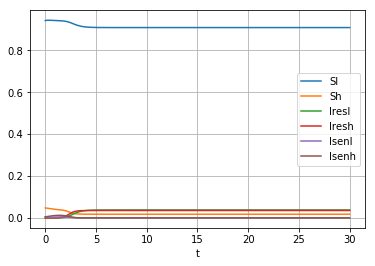

In [5]:
plt.figure()
plt.plot(t, sol_msm[1,:, 0], label='Sl')
plt.plot(t, sol_msm[1,:, 1], label='Sh')
plt.plot(t, sol_msm[1,:, 2], label='Iresl')
plt.plot(t, sol_msm[1,:, 3], label='Iresh')
plt.plot(t, sol_msm[1,:, 4], label='Isenl')
plt.plot(t, sol_msm[1,:, 5], label='Isenh')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

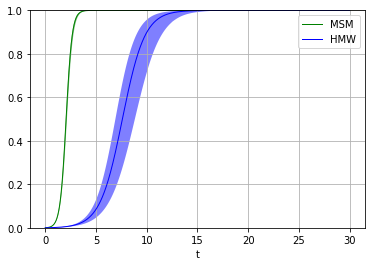

In [6]:
plt.figure()

ratio_sol_msm = (sol_msm[:,:, 2] + sol_msm[:,:, 3])/(sol_msm[:,:, 2] + sol_msm[:,:, 3] + sol_msm[:,:, 4] + sol_msm[:,:, 5])
plt.plot(t, ratio_sol_msm[1,:], label = "MSM", c = "g",linewidth=1)
plt.fill_between(t,ratio_sol_msm[0,:], ratio_sol_msm[2,:], alpha=0.5, facecolor = "g")

ratio_sol_hmw = (sol_hmw[:,:, 2] + sol_hmw[:,:, 3])/(sol_hmw[:,:, 2] + sol_hmw[:,:, 3] + sol_hmw[:,:, 4] + sol_hmw[:,:, 5])
plt.plot(t, ratio_sol_hmw[1,:], label = "HMW", c = "b",linewidth=1)
plt.fill_between(t,ratio_sol_hmw[0,:], ratio_sol_hmw[2,:], alpha=0.5, facecolor = "b")



plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.ylim(0,1)
plt.show()

# Simple Contact network

## Build a network

exponent = -2.40
graph has 1791 parallel edges
size of largest connected component = 902


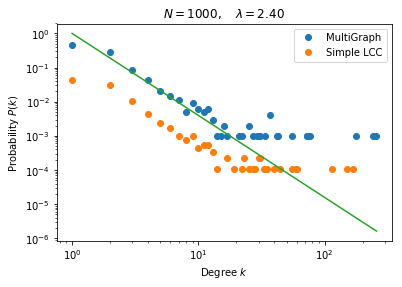

<function networkx.generators.random_graphs.powerlaw_cluster_graph(n, m, p, seed=None)>

In [3]:
#### code from http://nbviewer.jupyter.org/gist/Midnighter/248f1a5d8c21b39525ae

exp = 2.4
seed = 123456789
num = 1000
print("exponent = -{0:.2f}".format(exp))
sequence = create_degree_sequence(num, powerlaw_sequence, exponent=exp)
graph = nx.configuration_model(sequence, seed=seed)
# count parallel edges and avoid counting A-B as well as B-A
num_par = sum(
    len(graph[node][neigh]) for node in graph
    for neigh in graph.neighbors(node)) // 2
print("graph has {0:d} parallel edges".format(num_par))
loops = graph.selfloop_edges()
# remove them
graph = nx.Graph(graph)
graph.remove_edges_from(loops)
# get largest connected component
# unfortunately, the iterator over the components is not guaranteed to be sorted by size
components = sorted(nx.connected_components(graph), key=len, reverse=True)
lcc = graph.subgraph(components[0])
print("size of largest connected component = {0:d}".format(len(lcc)))
# new degree sequence
simple_seq = [deg for (node, deg) in lcc.degree()]
# create histograms
counts = np.bincount(sequence)
mask = (counts > 0)
plt.figure()
plt.plot(
    np.arange(len(counts))[mask],
    counts[mask] / counts.sum(),
    "o",
    label="MultiGraph")
simple_counts = np.bincount(simple_seq)
mask = (simple_counts > 0)
# distribution is shifted for visibility
plt.plot(
    np.arange(len(simple_counts))[mask],
    simple_counts[mask] / simple_counts.sum() / 10.0,
    "o",
    label="Simple LCC")
x = np.arange(1, len(counts))
plt.plot(x, np.power(x, -exp))
plt.xlabel(r"Degree $k$")
plt.xscale("log")
plt.ylabel(r"Probability $P(k)$")
plt.yscale("log")
plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num, exp))
plt.legend(loc="best")
plt.show()
nx.powerlaw_cluster_graph

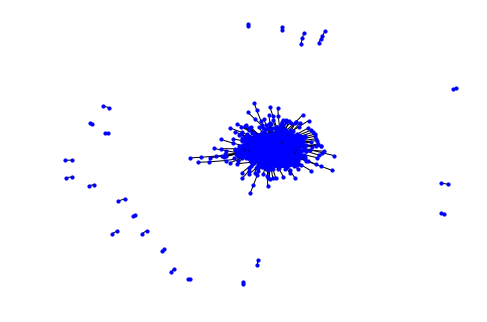

In [3]:
plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=10, with_labels=False)
plt.show()

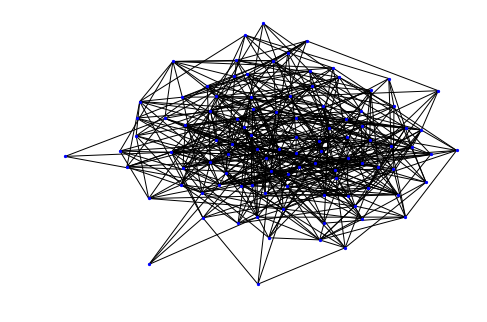

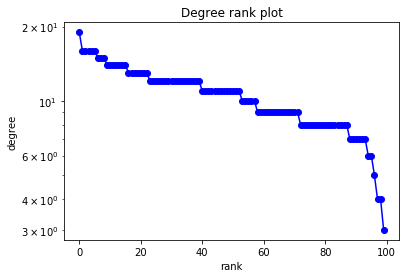

In [4]:
p = 0.1
num = 100
graph = nx.fast_gnp_random_graph(num, p, seed=seed, directed=False)

plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=5, with_labels=False)
plt.show()

plt.figure()
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.semilogy(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

## Implementation of disease spreading

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds

init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((2, num_steps))
num_res = np.zeros((2, num_steps))

for sextype in range(2):
    phi = PHI[sextype]
    beta = BETA[sextype]

    beta = 1 - (1 - beta)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi

    
    num_res[sextype,:], num_infected[sextype,:]= network_model(beta, tau, nu, mu, init, num_steps, copy.deepcopy(graph), True)

 10%|█         | 743/7300 [00:00<00:07, 819.97it/s] 